## Hate Speech Detection

Here the model the classification model from Indonesian Hate Speech Dataet (https://github.com/ialfina/id-hatespeech-detection).
We will create model to detect hate speech.

In [67]:
!pip install Sastrawi
!pip install nltk

In [112]:
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import re
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RIZQI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RIZQI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
df = pd.read_csv('data/hate-speech/IDHSD_RIO_unbalanced_713_2017.txt', sep='\t', header=None, names=['label', 'tweet'], skiprows=1, engine='python')
df.head()

,label,tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


### Exploratory Data Analysis

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 713 entries, 0 to 712
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   713 non-null    object
 1   tweet   713 non-null    object
dtypes: object(2)
memory usage: 11.3+ KB


In [115]:
df.isnull().sum()

label    0
tweet    0
dtype: int64

In [116]:
list_account = []
for i in df['tweet']:
    for j in i.split():
        if '@' in j:
            list_account.append(re.sub(':', '', j))
# list_account

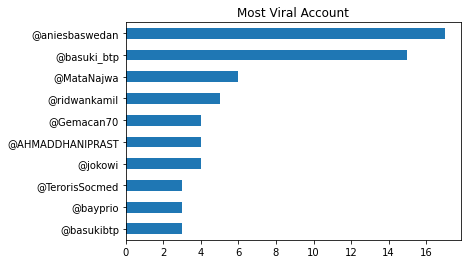

In [119]:
plt.title('Most Viral Account')
pd.DataFrame({'account' : list_account})['account'].value_counts()[0:10].sort_values(ascending=True).plot(kind='barh')

In [128]:
# df.loc['label' : 'Non_HS']

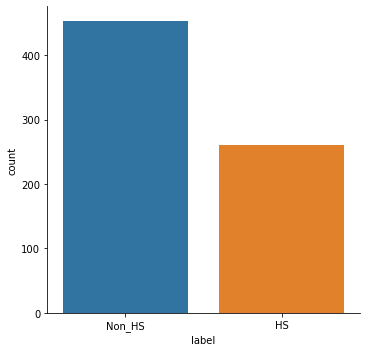

In [5]:
sns.catplot(x='label', kind='count', data=df, orient='h')

### Data Preprocessing

In [6]:
# Label Encoding
le = preprocessing.LabelEncoder()
le.fit(df['label'])

LabelEncoder()

In [7]:
# le.classes_

In [8]:
df['label'] = le.transform(df['label'])
df.head()

,label,tweet
0,1,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,1,RT @baguscondromowo: Mereka terus melukai aksi...
2,1,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,1,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,1,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


In [9]:
df.head()

,label,tweet
0,1,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,1,RT @baguscondromowo: Mereka terus melukai aksi...
2,1,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,1,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,1,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


#### Filtering

In [11]:
# Filtering
def filtering(tweet):
    #remove special character
    result = re.sub('[^A-Za-z0-9]+', ' ', tweet)
    #remove https
    result = re.sub('https ', '', result)
    #remove number
    result = re.sub(r"\d+", '', result)
    return result

df['tweet_filtering'] = df['tweet'].apply(filtering)
df.head()

,label,tweet,tweet_filtering
0,1,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,RT spardaxyz Fadli Zon Minta Mendagri Segera M...
1,1,RT @baguscondromowo: Mereka terus melukai aksi...,RT baguscondromowo Mereka terus melukai aksi d...
2,1,Sylvi: bagaimana gurbernur melakukan kekerasan...,Sylvi bagaimana gurbernur melakukan kekerasan ...
3,1,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",Ahmad Dhani Tak Puas Debat Pilkada Masalah Jal...
4,1,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,RT lisdaulay28 Waspada KTP palsu kawal PILKADA...


#### Stemming

In [12]:
# Stemming
def stemming(tweet):
    stemmer = StemmerFactory().create_stemmer()
    result = stemmer.stem(tweet)
    return result

df['tweet_stemming'] = df['tweet_filtering'].apply(stemming)
df.head()

,label,tweet,tweet_filtering,tweet_stemming
0,1,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...,RT spardaxyz Fadli Zon Minta Mendagri Segera M...,rt spardaxyz fadli zon minta mendagri segera n...
1,1,RT @baguscondromowo: Mereka terus melukai aksi...,RT baguscondromowo Mereka terus melukai aksi d...,rt baguscondromowo mereka terus luka aksi dala...
2,1,Sylvi: bagaimana gurbernur melakukan kekerasan...,Sylvi bagaimana gurbernur melakukan kekerasan ...,sylvi bagaimana gurbernur laku keras perempuan...
3,1,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja...",Ahmad Dhani Tak Puas Debat Pilkada Masalah Jal...,ahmad dhani tak puas debat pilkada masalah jal...
4,1,RT @lisdaulay28: Waspada KTP palsu.....kawal P...,RT lisdaulay28 Waspada KTP palsu kawal PILKADA...,rt lisdaulay28 waspada ktp palsu kawal pilkada...


#### Remove Stop Words and Vectorizer

In [65]:
# Remove Stop Words
sw = stopwords.words('indonesian')

vect = TfidfVectorizer(stop_words=sw)

x = df['tweet_stemming']
y = df['label']

# vectorizer
x = vect.fit_transform(x)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


#### Set Training and Testing Data

In [17]:
# Set Training and Testing Data (70:30)
x_train, x_test, y_train, y_test  = train_test_split(x , y, shuffle = True, test_size=0.3, random_state=1)

# Show the Training and Testing Data
print(f"""{x_train.shape}  \n{x_test.shape}  \n{y_train.shape}  \n{y_test.shape} """)

(499, 2422)  
(214, 2422)  
(499,)  
(214,) 


#### Custom Function for Evaluation

list_model = []
list_acc = []
list_precision = []
list_recall = []

def evaluation(m):
    model = m
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    acc = round(metrics.accuracy_score(y_test, y_pred),2)
    prec = round(metrics.precision_score(y_test, y_pred),2)
    recall = round(metrics.recall_score(y_test, y_pred),2)
    list_model.append(str(model).split('(')[0])
    list_acc.append(acc)
    list_precision.append(prec)
    list_recall.append(recall)
    #print(f"""{str(model).split('(')[0]} \nAccuracy : {acc} \nPrecision : {prec} \nRecall : {recall}""")
    print(f"""Algorithm : {str(model).split('(')[0]} \n {classification_report(y_test,y_pred)} """)

#### Support Vector Machine

In [19]:
evaluation(SVC())

Algorithm : SVC 
               precision    recall  f1-score   support

           0       0.92      0.56      0.70        84
           1       0.77      0.97      0.86       130

    accuracy                           0.81       214
   macro avg       0.85      0.76      0.78       214
weighted avg       0.83      0.81      0.80       214
 


#### K Neirest Neighbors

In [20]:
evaluation(KNeighborsClassifier())

Algorithm : KNeighborsClassifier 
               precision    recall  f1-score   support

           0       0.80      0.68      0.74        84
           1       0.81      0.89      0.85       130

    accuracy                           0.81       214
   macro avg       0.81      0.79      0.79       214
weighted avg       0.81      0.81      0.80       214
 


#### Decision Tree

In [21]:
evaluation(tree.DecisionTreeClassifier())

Algorithm : DecisionTreeClassifier 
               precision    recall  f1-score   support

           0       0.77      0.69      0.73        84
           1       0.81      0.87      0.84       130

    accuracy                           0.80       214
   macro avg       0.79      0.78      0.78       214
weighted avg       0.80      0.80      0.80       214
 


#### Random Forest

In [25]:
evaluation(RandomForestClassifier())

Algorithm : RandomForestClassifier 
               precision    recall  f1-score   support

           0       0.89      0.65      0.75        84
           1       0.81      0.95      0.87       130

    accuracy                           0.83       214
   macro avg       0.85      0.80      0.81       214
weighted avg       0.84      0.83      0.83       214
 


#### Model Comparison

In [24]:
df_summary = pd.DataFrame({'Algoritma' : list_model, 'Accuracy' : list_acc, 'Precision' : list_precision, 'Recall' : list_recall})
df_summary.sort_values(by='Accuracy',ascending=False)

,Algoritma,Accuracy,Precision,Recall
0,SVC,0.81,0.77,0.97
1,KNeighborsClassifier,0.81,0.81,0.89
2,DecisionTreeClassifier,0.80,0.81,0.87


#### Model Selection

In [27]:
model = RandomForestClassifier()
round(cross_val_score(model,x,y,cv=20).mean(),2)

0.84

#### Hyperparameter tuning

In [28]:
param_grid = {'criterion' : ['gini','entropy'],
'max_features' : ['auto','sqrt','log2'],
'n_estimators' : [100,200,300],
'class_weight' : ['balanced','balanced_subsample']}

gsv = GridSearchCV(RandomForestClassifier(),param_grid=param_grid,n_jobs=4,cv=5)
gsv.fit(x,y)
print(gsv.best_params_)
print(gsv.best_score_)

{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 200}
0.8331921599527234


In [29]:
model = RandomForestClassifier(**gsv.best_params_)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.67      0.90      0.77        62
           1       0.95      0.82      0.88       152

    accuracy                           0.84       214
   macro avg       0.81      0.86      0.82       214
weighted avg       0.87      0.84      0.85       214



In [30]:
cross_val_score(model,x,y,cv=5).mean()

0.8275780557470698

### Conclusion

After the prediction process using Random Forest Classifier Algorithm and evaluation process using cross validation, it obtained accuracy of **82.19%**. This means that this algorithm has an error tolerance of **17.81 %**.

In [31]:
# end